<h1>Import libraries<h1>

In [1]:
from Model.Histogram_Gradient_Boosting_Classifier import *
from Model.Histogram_Gradient_Boosting_Regressor import *
from Model.Histogram_Gradient_Boosting_optimization import *
from Metrics.Classification_metrics import *
from Metrics.Regression_metrics import *
from Plots.Prediction_plots import *
Plots_predictions = Prediction_plots()

<h1>Explanation of Histogram Gradient Boosting<h1>

$\text{Histogram Gradient Boosting is an algorithm that can be used for both regression and classification problems.}$<p>
$\text{In this case, boosting involves determining subsequent predictions taking into account the errors of preceding estimators.}$

<h2>Construction of Histogram Gradient Boosting<h2>

$\text{The scheme in building and determining the prediction looks analogous to Gradient Boosting, which was discussed here: }$ [Gradient Boosting example](https://github.com/kvbiii/ML_Algorithms_from_scratch/blob/main/Gradient_Boosting/Gradient_Boosting_example.ipynb)<p> 
$\text{The main difference is the transformation of the input data and their "binning," that is, aggregation into bundles.}$<p>
$\text{The scheme for determining the bundles for each variable is as follows:}$<p><br>
$\text{Continous Variables:}$<p>
$\text{- If } N < max\_bins: \text{ each basket will contain one observation each.}$<p>
$\text{- If } N \geq max\_bins: \text{ we sort the variable, and then assign them to the appropriate bundles}$<p> 
$\text{(this can be done, for example, using a histogram, where } max\_bin \text{ is the number of bars, and the values from each bar will go into the designated bundle).}$<p><br>
$\text{Categorical Variables:}$<p>
$\text{Each category goes into separate basket.}$<p>
$\text{The exception is when the number of observations for a unique category is less than } 0.01\times N,$<p> $\text{in which case the category is "skipped" and goes to the basket with the highest number of observations.}$<p><br>
$\text{Missing Values:}$<p>
$\text{Missing values go to basket with the highest number of observation for current feature.}$

<h1>Preprocessing<h1>

<h1>Preprocessing<h1>

In [2]:
data = pd.read_csv("Data/bank-balanced.csv")
X = data.drop("deposit", axis=1)
y = data["deposit"]

In [3]:
print("Number of observations in data: {}".format(len(data)))
data.head()

Number of observations in data: 11162


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


<h2>Check for null data<h2>

In [4]:
data.isnull().sum()/len(data)

age          0.0
job          0.0
marital      0.0
education    0.0
default      0.0
balance      0.0
housing      0.0
loan         0.0
contact      0.0
day          0.0
month        0.0
duration     0.0
campaign     0.0
pdays        0.0
previous     0.0
poutcome     0.0
deposit      0.0
dtype: float64

<h2>Convert object to numeric<h2>

$\text{For Histogram Gradient Boosting we have to convert object/string features to numeric.}$<p>
$\text{For Histogram Gradient Boosting, the best option would be to use OridinalEncoding instead of OneHotEncoding because of that algorithm's problem with the curse of dimensionality}$

In [5]:
list_of_object_features_classification = data.select_dtypes(include="object").columns.tolist()
list_of_numeric_features_classification = data.select_dtypes(exclude="object").columns.tolist()
encoder = OrdinalEncoder()
data[list_of_object_features_classification] = encoder.fit_transform(data[list_of_object_features_classification])

<h2>Divide our data into train and test sets<h2>

In [6]:
target_binary = "deposit"
X = data.drop(target_binary, axis=1)
y = data[[target_binary]]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=17, test_size=0.2)

$\text{The huge advantage of Histogram Gradient Boosting compared to other popular algorithms is that there is no need to scale the data.}$

<h1>Modelling<h1>

$\text{To verify how well our algorithms are able to perform, a cross-validation will be used on the training set (in order to average the results obtained).}$<p>
$\text{Then we will check whether the algorithms will perform equally well (or even better) on the test data.}$

In [7]:
class Cross_Validation():
    def __init__(self, metric, algorithm_instance, cross_validation_instance):
        metrics = {"accuracy": [lambda y, y_pred: accuracy_score(y, y_pred), "preds"],
                    "roc_auc": [lambda y, y_pred: roc_auc_score(y, y_pred), "probs"],
                    "mse": [lambda y, y_pred: mean_squared_error(y, y_pred), "preds"],
                    "rmse": [lambda y, y_pred: mean_squared_error(y, y_pred)**0.5, "preds"],
                    "mae": [lambda y, y_pred: mean_absolute_error(y, y_pred), "preds"]}
        if metric not in metrics:
            raise ValueError('Unsupported metric: {}'.format(metric))
        self.eval_metric = metrics[metric][0]
        self.metric_type = metrics[metric][1]
        self.algorithm = algorithm_instance
        self.cv = cross_validation_instance
    
    def fit(self, X, y, verbose=False):
        X = self.check_X(X=X)
        y = self.check_y(y=y)
        self.train_scores, self.valid_scores = [], []
        for iter, (train_idx, valid_idx) in enumerate(self.cv.split(X, y)):
            X_train, X_valid = X[train_idx, :], X[valid_idx, :]
            y_train, y_valid = y[train_idx], y[valid_idx]
            self.algorithm.fit(X_train, y_train)
            if(self.metric_type == "preds"):
                y_train_pred = self.algorithm.predict(X_train)
                y_valid_pred = self.algorithm.predict(X_valid)
            else:
                y_train_pred = self.algorithm.predict_proba(X_train)[:, 1]
                y_valid_pred = self.algorithm.predict_proba(X_valid)[:, 1]
            self.train_scores.append(self.eval_metric(y_train, y_train_pred))
            self.valid_scores.append(self.eval_metric(y_valid, y_valid_pred))
            if(verbose == True):
                print("Iter {}: train scores: {}; valid scores: {}".format(iter, np.round(self.eval_metric(y_train, y_train_pred), 5), np.round(self.eval_metric(y_valid, y_valid_pred), 5)))
        return np.mean(self.train_scores), np.mean(self.valid_scores)
    
    def check_X(self, X):
        if not isinstance(X, pd.DataFrame) and not isinstance(X, np.ndarray) and not torch.is_tensor(X):
            raise TypeError('Wrong type of X. It should be dataframe, numpy array or torch tensor.')
        X = np.array(X)
        if(X.ndim == 1):
            X = X[None, :]
        return X
    
    def check_y(self, y):
        if not isinstance(y, pd.DataFrame) and not isinstance(y, pd.Series) and not isinstance(y, np.ndarray) and not torch.is_tensor(y):
            raise TypeError('Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array or torch tensor.')
        y = np.array(y)
        if(y.ndim == 2):
            y = y.squeeze()
        return y

In [8]:
list_of_object_features_without_target = list_of_object_features_classification.copy()
list_of_object_features_without_target.remove(target_binary)

In [9]:
model = Histogram_Gradient_Boosting_Classifier(n_estimators=100, learning_rate=0.5, loss="log_loss", criterion="squared_error", max_depth=3, max_bins=255, random_state=17)
CV = Cross_Validation(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=True)
print("Mean of train scores: {}; Mean of valid scores: {}".format(np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

Iter 0: train scores: 0.96477; valid scores: 0.89369
Iter 1: train scores: 0.96599; valid scores: 0.8734
Iter 2: train scores: 0.96607; valid scores: 0.90646
Iter 3: train scores: 0.96763; valid scores: 0.89071
Iter 4: train scores: 0.96412; valid scores: 0.90617
Mean of train scores: 0.96572; Mean of valid scores: 0.89409


$\text{As we can see our algorithm performs well on training dataset but worse on validation dataset.}$

$\text{Check the results for original test dataset.}$

In [11]:
model = Histogram_Gradient_Boosting_Classifier(n_estimators=100, learning_rate=0.5, loss="log_loss", criterion="squared_error", max_depth=3, max_bins=255, random_state=17)
model.fit(X_train, y_train)
y_prob_train = model.predict_proba(X_train)[:,1]
y_prob_test = model.predict_proba(X_test)[:,1]
print("Histogram Gradient Boosting Classifier: Train: {}; Test: {}".format(np.round(roc_auc_score(y_train, y_prob_train), 4), np.round(roc_auc_score(y_test, y_prob_test), 4)))

Histogram Gradient Boosting Classifier: Train: 0.9622; Test: 0.9105


$\text{Write down predictions for the future}$

In [12]:
base_predictions = model.predict(X_test)
base_probabilities = model.predict_proba(X_test)[:, 1]

$\text{We will try to tune hyperparameters to see whether we can improve accuracy.}$<p>
$\text{To perform optimization we will use sklearn Histogram Gradient Boosting just because of faster compilation time.}$

<h1>Optimization<h1>

$\text{Let's start tuning with } max\_iter \text{ parameter.}$<p>
$max\_iter \ [int] \text{: specifying the number of estimators used in building the histogram gradient boosting.}$<p>
$\text{A larger number of trees reduces the likelihood of overfitting (better averaging/more models considered for voting)}$<p>
$\text{On the other hand, larger number of estimators leads to more models to train, i.e. longer compilation time.}$<p>
$\text{As a rule, a value of 50 should be sufficient, but an optimal value can be found through cross-validation.}$

In [13]:
model = HistGradientBoostingClassifier(random_state=17, categorical_features=list_of_object_features_without_target)
CV = Cross_Validation_Histogram_Gradient_Boosting_optimization(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for max_iter in range(10, 250, 30):
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, max_iter=max_iter)
    print("max_iter: {}; Mean of train scores: {}; Mean of valid scores: {}".format(max_iter, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

max_iter: 10; Mean of train scores: 0.929; Mean of valid scores: 0.91217
max_iter: 40; Mean of train scores: 0.95734; Mean of valid scores: 0.92411
max_iter: 70; Mean of train scores: 0.97459; Mean of valid scores: 0.92566
max_iter: 100; Mean of train scores: 0.98458; Mean of valid scores: 0.9257
max_iter: 130; Mean of train scores: 0.9904; Mean of valid scores: 0.92541
max_iter: 160; Mean of train scores: 0.99411; Mean of valid scores: 0.92491
max_iter: 190; Mean of train scores: 0.99656; Mean of valid scores: 0.92458
max_iter: 220; Mean of train scores: 0.99795; Mean of valid scores: 0.92395


$\text{We see that as we increase the max iter in the Histogram Gradient Boosting, our algorithm gets better results.}$<p>
$\text{However, from the level of } max\_iter \approx 100 \text{ we can see a exacerbation, for this reason value of 100 will be used in further optimization.}$

$learning\_rate \ [float]: \text{ controls the loss function used for calculating the weight of the estimators.}$

In [14]:
model = HistGradientBoostingClassifier(random_state=17, categorical_features=list_of_object_features_without_target, max_iter=100)
CV = Cross_Validation_Histogram_Gradient_Boosting_optimization(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for learning_rate in np.linspace(0.01, 0.3, 10):
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, learning_rate=learning_rate)
    print("learning_rate: {}; Mean of train scores: {}; Mean of valid scores: {}".format(learning_rate, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

learning_rate: 0.01; Mean of train scores: 0.93002; Mean of valid scores: 0.91373
learning_rate: 0.042222222222222223; Mean of train scores: 0.95889; Mean of valid scores: 0.92501
learning_rate: 0.07444444444444444; Mean of train scores: 0.97629; Mean of valid scores: 0.9266
learning_rate: 0.10666666666666666; Mean of train scores: 0.9863; Mean of valid scores: 0.92678
learning_rate: 0.1388888888888889; Mean of train scores: 0.99147; Mean of valid scores: 0.92414
learning_rate: 0.1711111111111111; Mean of train scores: 0.99507; Mean of valid scores: 0.92438
learning_rate: 0.20333333333333334; Mean of train scores: 0.99693; Mean of valid scores: 0.9238
learning_rate: 0.23555555555555557; Mean of train scores: 0.99838; Mean of valid scores: 0.92117
learning_rate: 0.2677777777777778; Mean of train scores: 0.99925; Mean of valid scores: 0.92101
learning_rate: 0.3; Mean of train scores: 0.99954; Mean of valid scores: 0.9196


$\text{Best results are obtained for } learning\_rate \approx 0.106$

$max\_bins \ [int]: \text{ the maximum number of bins to use for non-missing values..}$

In [15]:
model = HistGradientBoostingClassifier(random_state=17, categorical_features=list_of_object_features_without_target, max_iter=100, learning_rate=0.106)
CV = Cross_Validation_Histogram_Gradient_Boosting_optimization(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for max_bins in range(20, 255, 30):
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, max_bins=max_bins)
    print("max_bins: {}; Mean of train scores: {}; Mean of valid scores: {}".format(max_bins, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

max_bins: 20; Mean of train scores: 0.9827; Mean of valid scores: 0.92707
max_bins: 50; Mean of train scores: 0.9844; Mean of valid scores: 0.92607
max_bins: 80; Mean of train scores: 0.98484; Mean of valid scores: 0.92667
max_bins: 110; Mean of train scores: 0.98497; Mean of valid scores: 0.92711
max_bins: 140; Mean of train scores: 0.98569; Mean of valid scores: 0.9259
max_bins: 170; Mean of train scores: 0.98575; Mean of valid scores: 0.92724
max_bins: 200; Mean of train scores: 0.98578; Mean of valid scores: 0.92616
max_bins: 230; Mean of train scores: 0.98606; Mean of valid scores: 0.92612


$\text{Best results are obtained for } max\_bins \approx 170$

$max\_depth \ [int]: \text{ is used to control the depth of the tree (its downward expansion).}$<p>
$\text{The greater the depth of the tree, the greater the likelihood of overfitting.}$<p>
$\text{On the other hand, too low depth can lead to underfitting.}$

In [16]:
model = HistGradientBoostingClassifier(random_state=17, categorical_features=list_of_object_features_without_target, max_iter=100, learning_rate=0.106, max_bins=170)
CV = Cross_Validation_Histogram_Gradient_Boosting_optimization(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for max_depth in range(2, 30, 3):
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, max_depth=max_depth)
    print("max_depth: {}; Mean of train scores: {}; Mean of valid scores: {}".format(max_depth, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

max_depth: 2; Mean of train scores: 0.92211; Mean of valid scores: 0.91284
max_depth: 5; Mean of train scores: 0.96964; Mean of valid scores: 0.92614
max_depth: 8; Mean of train scores: 0.9837; Mean of valid scores: 0.92595
max_depth: 11; Mean of train scores: 0.98569; Mean of valid scores: 0.92599
max_depth: 14; Mean of train scores: 0.9853; Mean of valid scores: 0.926
max_depth: 17; Mean of train scores: 0.98575; Mean of valid scores: 0.92724
max_depth: 20; Mean of train scores: 0.98575; Mean of valid scores: 0.92724
max_depth: 23; Mean of train scores: 0.98575; Mean of valid scores: 0.92724
max_depth: 26; Mean of train scores: 0.98575; Mean of valid scores: 0.92724
max_depth: 29; Mean of train scores: 0.98575; Mean of valid scores: 0.92724


$\text{The biggest valid score was obtained for } max\_depth \approx 17$

<h1>Evaluation and Visualization<h1>

In [17]:
print("Balance accuracy score: {}".format(np.round(balanced_accuracy_score(y_true=y_test, y_pred=base_predictions), 5)))
print("Roc AUC score: {}".format(np.round(roc_auc_score(y_true=y_test, y_score=base_probabilities), 5)))
report = classification_report(y_test, base_predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
print(tabulate(df, headers="keys", tablefmt = 'psql'))

Balance accuracy score: 0.84216
Roc AUC score: 0.91053
+--------------+-------------+----------+------------+-------------+
|              |   precision |   recall |   f1-score |     support |
|--------------+-------------+----------+------------+-------------|
| 0.0          |    0.873371 | 0.810717 |   0.840879 | 1157        |
| 1.0          |    0.811044 | 0.873606 |   0.841163 | 1076        |
| accuracy     |    0.841021 | 0.841021 |   0.841021 |    0.841021 |
| macro avg    |    0.842207 | 0.842162 |   0.841021 | 2233        |
| weighted avg |    0.843338 | 0.841021 |   0.841016 | 2233        |
+--------------+-------------+----------+------------+-------------+


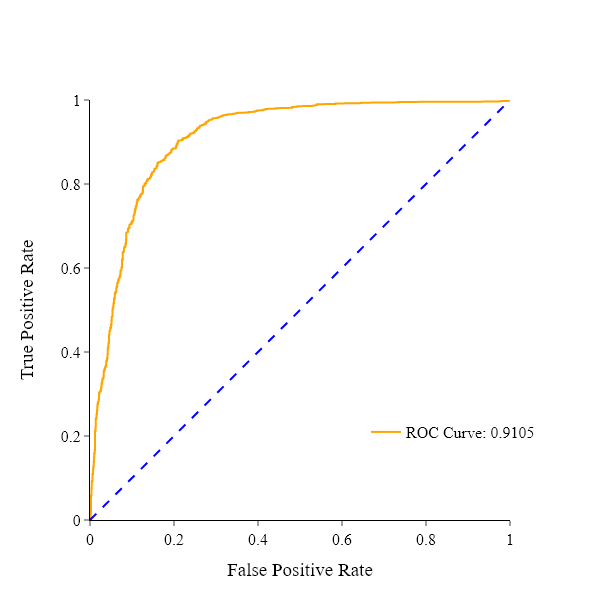

In [18]:
Plots_predictions.roc_auc_plot(y_true=y_test, y_prob=base_probabilities)

$\text{Final estimator: } max\_iter=100, \ learning\_rate=0.106, \ max\_bins=170, \ max\_depth=17$

In [19]:
final_algorithm_optimized = HistGradientBoostingClassifier(random_state=17, categorical_features=list_of_object_features_without_target, max_iter=100, learning_rate=0.106, max_bins=170, max_depth=17)
final_algorithm_optimized.fit(X_train, np.array(y_train).squeeze())
y_pred_final_optimized = final_algorithm_optimized.predict(X_test)
y_prob_final_optimized = final_algorithm_optimized.predict_proba(X_test)[:, 1]
print("Balance accuracy score: {}".format(np.round(balanced_accuracy_score(y_true=y_test, y_pred=y_pred_final_optimized), 5)))
print("Roc AUC score: {}".format(np.round(roc_auc_score(y_true=y_test, y_score=y_prob_final_optimized), 5)))
report = classification_report(y_test, y_pred_final_optimized, output_dict=True)
df = pd.DataFrame(report).transpose()
print(tabulate(df, headers="keys", tablefmt = 'psql'))

Balance accuracy score: 0.86643
Roc AUC score: 0.93021
+--------------+-------------+----------+------------+-------------+
|              |   precision |   recall |   f1-score |     support |
|--------------+-------------+----------+------------+-------------|
| 0.0          |    0.880995 | 0.85739  |   0.869032 | 1157        |
| 1.0          |    0.850949 | 0.875465 |   0.863033 | 1076        |
| accuracy     |    0.866099 | 0.866099 |   0.866099 |    0.866099 |
| macro avg    |    0.865972 | 0.866427 |   0.866032 | 2233        |
| weighted avg |    0.866517 | 0.866099 |   0.866141 | 2233        |
+--------------+-------------+----------+------------+-------------+


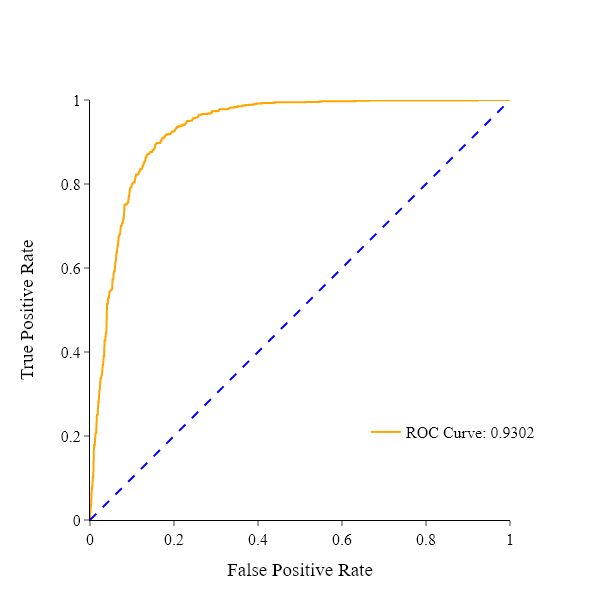

In [20]:
Plots_predictions.roc_auc_plot(y_true=y_test, y_prob=y_prob_final_optimized)

$\text{As we can see hyperparameter tuning have improved the effectiveness of the Histogram Gradient Boosting Classifier!}$

<h2>Histogram Gradient Boosting Regressor<h2>

<h2>Download data<h2>

In [21]:
data = pd.read_csv("Data/Sales.csv")
X = data.drop("Sales", axis=1)
y = data["Sales"]

In [22]:
print("Number of observations in data: {}".format(len(data)))
data.head()

Number of observations in data: 4572


,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,Mega,54.732757
1,13.0,9.237765,2.409567,Mega,46.677897
2,41.0,15.886446,2.913410,Mega,150.177829
3,83.0,30.020028,6.922304,Mega,298.246340
4,15.0,8.437408,1.405998,Micro,56.594181


<h2>Check for null data<h2>

$\text{As described at the beginning of this notebook, there is no need to drop missing values in Histogram Gradient Boosting.}$<p>
$\text{These observations will be mapped to bundles with most observations.}$<p>
$\text{To check whether there is a difference we will construct two models: with and without these observations.}$<p>
$\text{Obviously, we have to drop rows where target variable contains null values.}$

In [23]:
target_binary = "Sales"
data = data[data[target_binary].notna()]

In [24]:
data_with_missing = data.copy()
data_without_missing = data.dropna()

<h2>Convert object to numeric<h2>

In [25]:
list_of_object_features = data_with_missing.select_dtypes(include="object").columns.tolist()
list_of_numeric_features = data_with_missing.select_dtypes(exclude="object").columns.tolist()
encoder = OrdinalEncoder()
data_with_missing[list_of_object_features] = encoder.fit_transform(data_with_missing[list_of_object_features])
data_without_missing[list_of_object_features] = encoder.fit_transform(data_without_missing[list_of_object_features])

<h2>Divide our data into train and test sets<h2>

In [26]:
X_with_missing = data_with_missing.drop(target_binary, axis=1)
y_with_missing = data_with_missing[[target_binary]]
X_train_with_missing, X_test_with_missing, y_train_with_missing, y_test_with_missing = train_test_split(X_with_missing, y_with_missing, shuffle=True, random_state=17, test_size=0.2)
X_without_missing = data_without_missing.drop(target_binary, axis=1)
y_without_missing = data_without_missing[[target_binary]]
X_train_without_missing, X_test_without_missing, y_train_without_missing, y_test_without_missing = train_test_split(X_without_missing, y_without_missing, shuffle=True, random_state=17, test_size=0.2)

<h1>Evaluation and Visualization<h1>

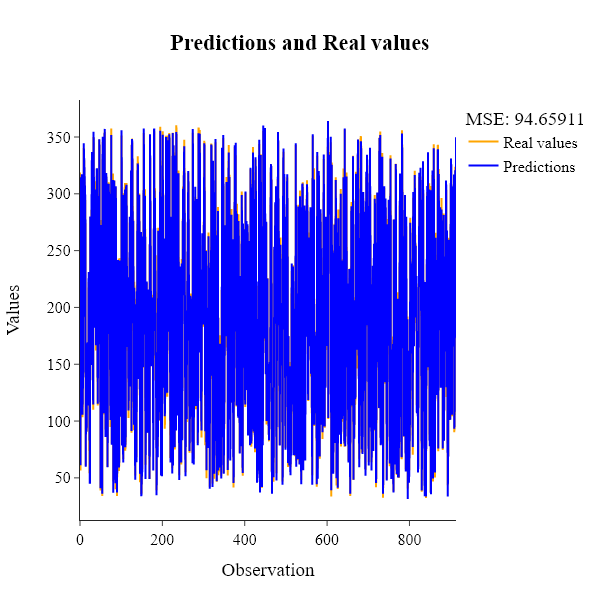

In [27]:
model = Histogram_Gradient_Boosting_Regressor(n_estimators=100, learning_rate=0.3, categorical_features=list_of_object_features, max_bins=255, random_state=17)
model.fit(X_train_with_missing, y_train_with_missing)
y_pred = model.predict(X_test_with_missing)
Plots_predictions.compare_predictions_with_real_values(y_true=y_test_with_missing, y_pred=y_pred, metric="MSE")

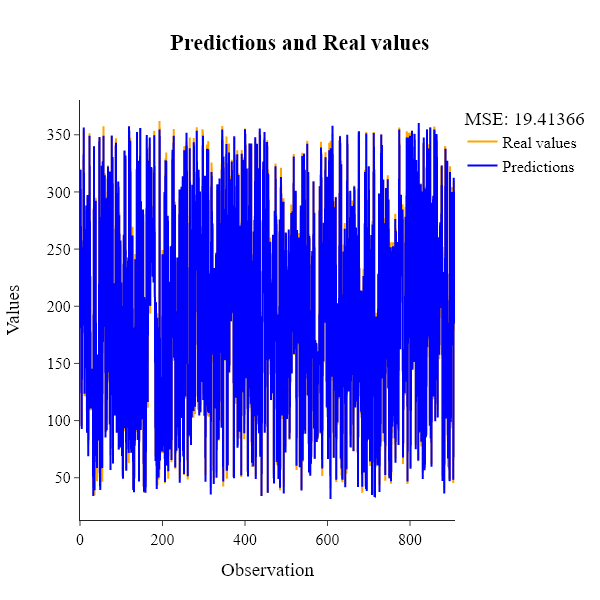

In [28]:
model = Histogram_Gradient_Boosting_Regressor(n_estimators=100, learning_rate=0.3, categorical_features=list_of_object_features, max_bins=255, random_state=17)
model.fit(X_train_without_missing, y_train_without_missing)
y_pred = model.predict(X_test_without_missing)
Plots_predictions.compare_predictions_with_real_values(y_true=y_test_without_missing, y_pred=y_pred, metric="MSE")

$\text{So as we can see, there is a slight difference between scores for each type of data.}$

<h2>Features importance<h2>

$\text{As with the random forest, the significance of the variables will be based on the estimators from which Ensemble was built.}$<p>
$$feature\_importnace_m=\frac{\sum_{t\in n u m b e r\ of\ trees}{feature\_importnace}_{m,t}}{number\ of\ trees}$$

$\text{Where: number of trees - the number of all trees in the forest,}$<p>
${feature\_importnace}_{m,t} \text{ - the importance of variable } m \text{ for tree } t.$

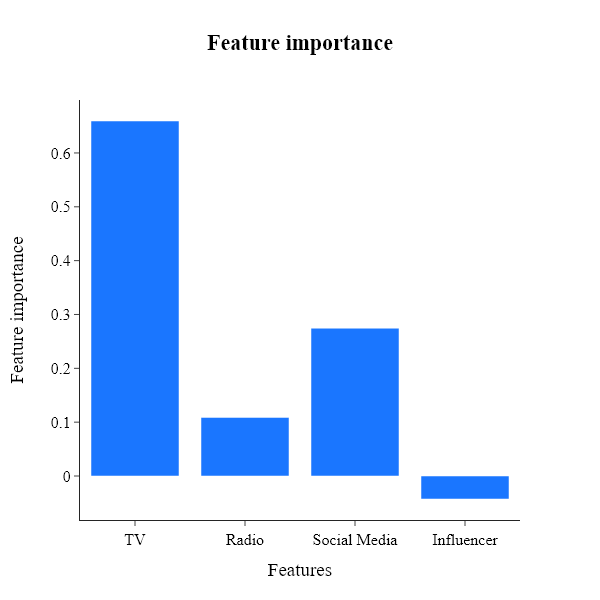

In [29]:
Plots_predictions.plot_feature_importances(feature_importances=list(model.normalized_feature_importances.values()), column_names=X.columns.tolist())

<h1>Advantages and disadvantages of Histogram Gradient Boosting<h1>

$\text{Advantages of Histogram Gradient Boosting:}$<p>
$\text{- Reduced computation time because we only consider the bundles, rather than all observations, when calculating the gains for each split,}$<p>
$\text{- Reduced memory usage,}$<p>
$\text{- Bundle grouping allows for more general patterns, so the error variance should be lower than when considering unique values.}$<br>

$\text{Disadvantages of Histogram Gradient Boosting:}$<p>
$\text{- By restricting the values to bundles, some information about the values of the variables is lost. This means a potential increase in error.}$